In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import GridSearchCV, KFold
from sklearn import pipeline, linear_model, base, ensemble, preprocessing

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from xgboost import XGBRFClassifier

%matplotlib inline

## Load the data

In [2]:
train_df = pd.read_csv("train.csv", index_col='PassengerId')
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_df = pd.read_csv('test.csv', index_col='PassengerId')
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
all_data = pd.concat([train_df, test_df], ignore_index=False)
all_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Initial data check

In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


<Axes: title={'center': 'Port of Embarkation'}>

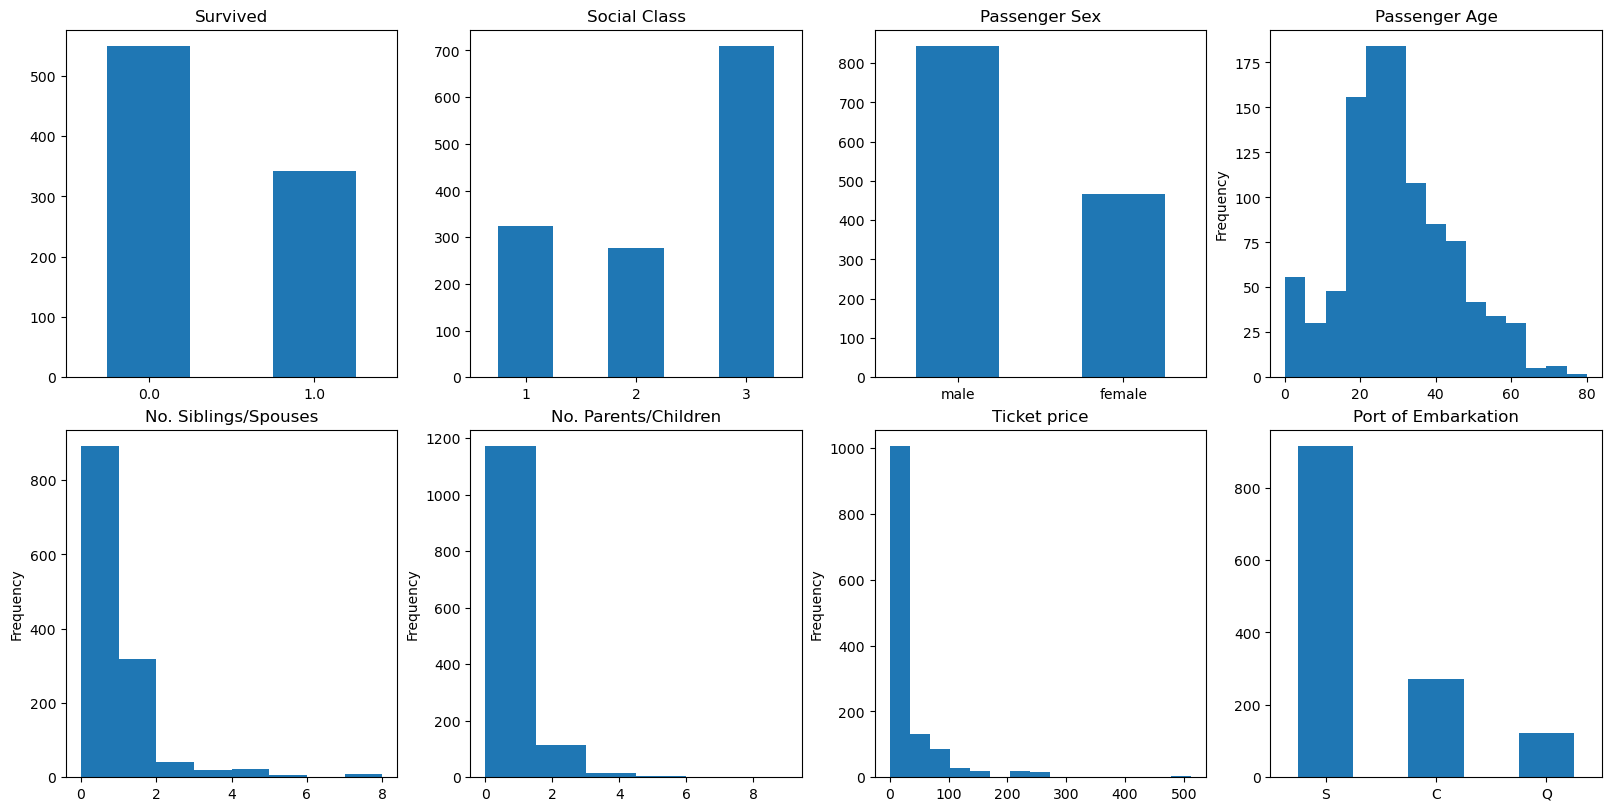

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=4, layout='constrained')
fig.set_size_inches(16, 8)

all_data['Survived'].value_counts().plot(kind='bar', title='Survived', rot=0, ax=axs[0, 0])
all_data['Pclass'].value_counts().sort_index().plot(kind='bar', title='Social Class', rot=0, ax=axs[0, 1])
all_data['Sex'].value_counts().plot(kind='bar', rot=0, title='Passenger Sex', ax=axs[0, 2])
all_data['Age'].plot(kind='hist', bins=15, title='Passenger Age', ax=axs[0, 3])
all_data['SibSp'].plot(kind='hist', bins=8, title='No. Siblings/Spouses', ax=axs[1, 0])
all_data['Parch'].plot(kind='hist', bins=6, title='No. Parents/Children', ax=axs[1, 1])
all_data['Fare'].plot(kind='hist', bins=15, title='Ticket price', ax=axs[1, 2])
all_data['Embarked'].value_counts().plot(kind='bar', title='Port of Embarkation', rot=0, ax=axs[1, 3])

## Handle missing values

In [7]:
all_data.isna().mean()

Survived    0.319328
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.200917
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000764
Cabin       0.774637
Embarked    0.001528
dtype: float64

In [8]:
# We have missing values for the following columns: Age, Cabin, Embarked, Fare

missing_data_cols =['Fare', 'Age', 'Embarked', 'Cabin']

all_data[missing_data_cols].isna().mean()

Fare        0.000764
Age         0.200917
Embarked    0.001528
Cabin       0.774637
dtype: float64

### Fill the missing values for Fare

In [9]:
all_data[all_data['Fare'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [10]:
# Let's take all the rows that are similar to our row above

mean_fare = all_data[
    (all_data['Pclass'] == 3)\
        & (all_data['Sex'] == 'male')\
        & (all_data['Age'] > 40)\
        & (all_data['Embarked'] == 'S')\
        & (all_data['SibSp'] == 0)\
        & (all_data['Parch'] == 0)]['Fare'].mean()

round(mean_fare)

8

In [11]:
all_data.loc[all_data['Fare'].isna(), 'Fare'] = round(mean_fare)
all_data[all_data['Fare'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


### Fill the missing values for Embarked

In [12]:
all_data[all_data['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [13]:
all_data.loc[all_data['Embarked'].isna(), 'Embarked'] = 'S'
all_data[all_data['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


### Transform the dataset

Extract the titles from the passenger names.
Some of the titles are synonymous to eachother. Below is an explanation of the ones that aren't functional titles (like Major, Dr, Rev)

Don == Mr (title used for men, in titanic for ages 11-80)  
Mlle == Miss (unmarried woman)  
Mme, Dona == Mrs (married woman)  
Master (title used for children)  
Ms (unknown marital status)  
Jonkheer - young lord (unmarried man)

In [14]:
def process_passenger_names(df):
    # Extract into separate columns the following
    # Last Name, Title, First Name, skip the dot after the Title
    name_parts = df['Name'].str.extractall(r'(.*),([^.]+)\.?(.*)')
    name_parts.columns = ['LastName', 'Title', 'FirstName']

    # Remove the 'match' index from the df
    name_parts = name_parts.reset_index(level=1, drop=True)

    # Remove the extra whitespace from cols
    for col in name_parts.columns:
        name_parts[col] = name_parts[col].str.strip(' ')

    # Convert the functional titles & synonymous titles to their simpler counterparts
    name_parts['Title'] = name_parts['Title'].replace(to_replace=['Dr', 'Rev', 'Major', 'Col', 'Capt'], value='Other')
    name_parts['Title'] = name_parts['Title'].replace(to_replace=['Sir', 'Don', 'Jonkheer'], value='Mr')
    name_parts['Title'] = name_parts['Title'].replace(to_replace=['Mlle'], value='Miss')
    name_parts['Title'] = name_parts['Title'].replace(to_replace=['Mme', 'the Countess', 'Dona'], value='Mrs')

    # The female passenger boarding ship bearing the title 'Ms' was actually married (link: https://www.encyclopedia-titanica.org/titanic-survivor/encarnacion-reynaldo.html)
    # So we can safely convert both to 'Mrs'
    lady_or_ms = name_parts['Title'].map(lambda title: title in ['Lady', 'Ms'])
    name_parts.loc[lady_or_ms, 'Title'] = 'Mrs'
    
    return name_parts

In [15]:
name_parts = process_passenger_names(all_data)
name_parts['Title'].value_counts()

Mr        760
Miss      262
Mrs       203
Master     61
Other      23
Name: Title, dtype: int64

In [16]:
all_data = all_data.join(name_parts, how='inner')
all_data = all_data.drop(columns=['Name'])

all_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,Title,FirstName
PassengerId,,,,,,,,,,,,,
1,0.0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
2,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
3,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
4,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel)
5,0.0,3,male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry


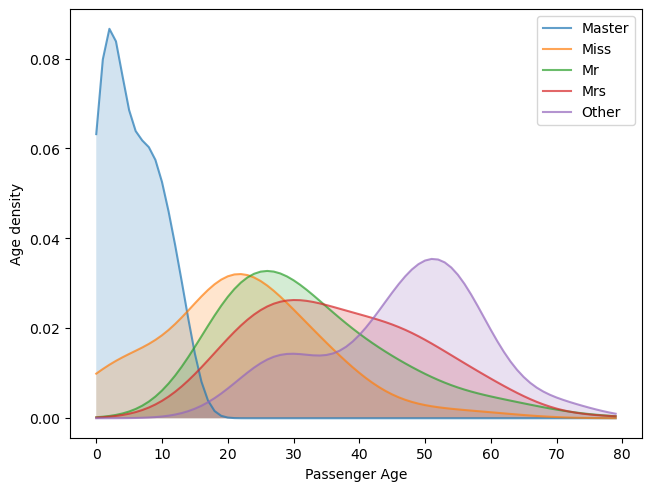

In [17]:
fig, ax = plt.subplots(layout='constrained')

age_vals = np.arange(0, 80)

for title_id, age_data in all_data.groupby('Title')['Age']:
    age_data = age_data.dropna().values
    age_density = stats.gaussian_kde(age_data, bw_method=0.5)(age_vals)
    ax.plot(age_vals, age_density, label=title_id, fillstyle='full', alpha=0.7)
    ax.fill_between(age_vals, np.zeros_like(age_vals), age_density, alpha=0.2)

ax.legend()
ax.set_xlabel('Passenger Age')
ax.set_ylabel('Age density')
plt.show()


In [18]:
def transform_dataset(df: pd.DataFrame):
    df_copy = df.copy()

    # Convert "Sex" to Categorical
    df_copy['Sex'] = df_copy['Sex'].map(lambda x: 0 if x == 'female' else 1).astype(np.uint8)

    # Convert 'Embarked' to categorical
    embarked_dummies = pd.get_dummies(df_copy['Embarked'])

    for col in embarked_dummies.columns:
        df_copy[col] = embarked_dummies[col]

    # Convert 'Fare' to nullable float
    df_copy['Fare'] = (np.round(df_copy['Fare'])).astype('Float32')

    # Convert 'Age' to integer values
    df_copy['Age'] = np.floor(df_copy['Age']).astype('Int32')

    # One-hot encode the 'Title' column
    title_dummies = pd.get_dummies(df['Title'])
    df_copy = df_copy.join(title_dummies)

    # Drop the columns we've one-hot encoded
    df_copy.drop(columns=['Title', 'Embarked'], inplace=True)

    return df_copy

Transform the categorical variables so we can use them for imputing the missing Age values.

In [19]:
final_df = transform_dataset(all_data)
final_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,LastName,FirstName,C,Q,S,Master,Miss,Mr,Mrs,Other
PassengerId,,,,,,,,,,,,,,,,,,,
1,0.0,3,1,22,1,0,A/5 21171,7.0,NaN,Braund,Owen Harris,0,0,1,0,0,1,0,0
2,1.0,1,0,38,1,0,PC 17599,71.0,C85,Cumings,John Bradley (Florence Briggs Thayer),1,0,0,0,0,0,1,0
3,1.0,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,Heikkinen,Laina,0,0,1,0,1,0,0,0
4,1.0,1,0,35,1,0,113803,53.0,C123,Futrelle,Jacques Heath (Lily May Peel),0,0,1,0,0,0,1,0
5,0.0,3,1,35,0,0,373450,8.0,NaN,Allen,William Henry,0,0,1,0,0,1,0,0


### Handle missing 'Age' values

In [20]:
final_df.corrwith(final_df['Age'], method='kendall', numeric_only=True).abs().sort_values(ascending=False)

Age         1.000000
Pclass      0.313345
Master      0.299075
Miss        0.238323
Mrs         0.187110
Parch       0.171594
Mr          0.146868
Fare        0.133160
Other       0.129809
SibSp       0.099729
C           0.067558
Sex         0.051542
S           0.050455
Survived    0.042841
Q           0.024825
dtype: float64

The 'Age' attribute is correlated with several other attributes such as 'PClass', 'Parch', and 'Titles' so it could be MAR, also, there's only ~20% missing data so we can safely impute the missing ones.

In [21]:
from sklearn import neighbors, svm


def get_imputer(df, imputing_columns, **imputer_kwargs):
    train_df_copy = df[imputing_columns]
    imputer = IterativeImputer(estimator=neighbors.KNeighborsRegressor(n_neighbors=20, weights='distance'), max_iter=10, random_state=0, **imputer_kwargs)
    imputer.fit(train_df_copy)
    
    return imputer


def fill_missing(df, imputer, imputing_columns, col_to_fill, missing_val=np.nan):
    partial_df = df[imputing_columns]
    col_idx = imputing_columns.index(col_to_fill)
    imputed_values = imputer.transform(partial_df)
    missing_mask = df[col_to_fill].isna() if missing_val is np.nan else df[col_to_fill] == missing_val
    df.loc[missing_mask, col_to_fill] = imputed_values[missing_mask, col_idx].astype(np.int32)
    df[col_to_fill] = df[col_to_fill].astype(np.int32)

    return df

In [22]:
# Use MICE to handle missing Age values

columns_for_age_imputing = ["Age", "Pclass", "Master", "Miss", "Mrs", "Fare", "Parch", "Mr", "Other", "SibSp"]
# columns_for_age_imputing = ['Age', 'Pclass', 'Parch', 'SibSp', 'Sex']
age_imputing_params = {
    'initial_strategy':'median',
    'min_value':0,
    'max_value':80
}

age_imputer = get_imputer(final_df, columns_for_age_imputing, **age_imputing_params)
final_df = fill_missing(final_df, age_imputer, columns_for_age_imputing, 'Age')

In [23]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    float64
 1   Pclass     1309 non-null   int64  
 2   Sex        1309 non-null   uint8  
 3   Age        1309 non-null   int32  
 4   SibSp      1309 non-null   int64  
 5   Parch      1309 non-null   int64  
 6   Ticket     1309 non-null   object 
 7   Fare       1309 non-null   Float32
 8   Cabin      295 non-null    object 
 9   LastName   1309 non-null   object 
 10  FirstName  1309 non-null   object 
 11  C          1309 non-null   uint8  
 12  Q          1309 non-null   uint8  
 13  S          1309 non-null   uint8  
 14  Master     1309 non-null   uint8  
 15  Miss       1309 non-null   uint8  
 16  Mr         1309 non-null   uint8  
 17  Mrs        1309 non-null   uint8  
 18  Other      1309 non-null   uint8  
dtypes: Float32(1), float64(1), int32(1), int64(3), o

<Axes: title={'center': 'Passenger Age'}, ylabel='Density'>

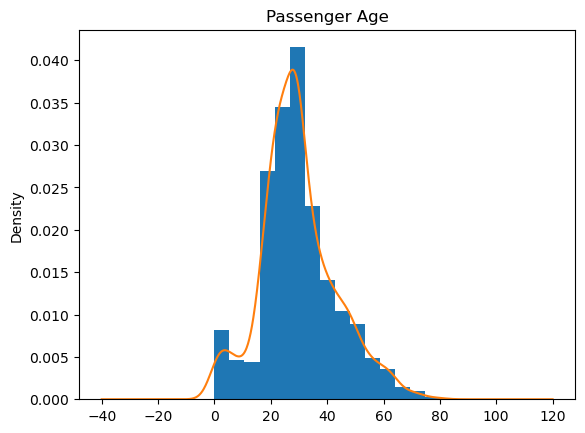

In [24]:
fig, ax = plt.subplots()

final_df['Age'].plot(kind='hist', density=True, bins=15, title='Passenger Age', ax=ax)
final_df['Age'].plot(kind='kde', ax=ax)

### Handle missing 'Cabin' values

In [25]:
final_df.Cabin.isna().mean()

0.774637127578304

In [26]:
# Let's impute using common sense (for passengers having the same ticket, add the same cabin number)

for id, row in final_df[~final_df['Cabin'].isna()].iterrows(): # for all rows where cabin not missing
    # take all rows that have same ticket as itself
    # set the same cabins
    same_ticket = final_df['Ticket'] == row['Ticket']
    missing_cabin = final_df['Cabin'].isna()
    final_df.loc[(same_ticket & missing_cabin), 'Cabin'] = row['Cabin']

In [27]:
final_df.Cabin.isna().mean()

0.7624140565317036

After the common-sense imputing there is 76% missing value for the 'Cabin' attribute.

In [28]:
# Identify which type of data missingness we have

missing_cabin = (~final_df.Cabin.isna()).astype(np.int32)

final_df.corrwith(missing_cabin, method='kendall', numeric_only=True).abs().sort_values(ascending=False)

Pclass      0.659648
Fare        0.488017
Survived    0.331576
C           0.278819
Age         0.236154
Mrs         0.167456
Sex         0.154767
S           0.151273
Q           0.149014
Mr          0.147556
SibSp       0.081467
Parch       0.078377
Other       0.061964
Master      0.038259
Miss        0.030292
dtype: float64

In [29]:
cabin_missing_by_class_counts = final_df.groupby(['Pclass', missing_cabin]).size()
cabin_missing_by_class_counts = cabin_missing_by_class_counts.reset_index()
cabin_missing_by_class_counts = cabin_missing_by_class_counts.pivot(index='Pclass', columns='Cabin', values=0)
cabin_missing_by_class_counts

Cabin,0,1
Pclass,,
1,54,269
2,253,24
3,691,18


In [30]:
table = cabin_missing_by_class_counts.values

chi_val, p_val, dof, expected = stats.chi2_contingency(table)
chi_val, p_val

(842.8618626174136, 9.437827370114478e-184)

In [31]:
cabin_missing_by_survival_counts  = final_df.groupby(['Survived', missing_cabin]).size()
cabin_missing_by_survival_counts = cabin_missing_by_survival_counts.reset_index()
cabin_missing_by_survival_counts = cabin_missing_by_survival_counts.pivot(index='Survived', columns='Cabin', values=0)
cabin_missing_by_survival_counts

Cabin,0,1
Survived,,
0.0,478,71
1.0,198,144


In [32]:
table = cabin_missing_by_survival_counts.values

chi_val, p_val, dof, expected = stats.chi2_contingency(table)
chi_val, p_val

(96.37170143528851, 9.521844790105262e-23)

The missing cabin values seem to be correlated with 'Pclass', 'Fare', 'Survived', 'Age', 'Sex' and ports so the data isn't MCAR.  
There's 65% correlation between the passenger Class and the missing Cabin and 31.7% w. r. t. the Survival and these correlations are statistically significant (p < 0.05).
This means that it was harder to retrieve the cabin number for lower class passengers or passengers that didn't survived.

Since the missingness of data is strongly related with other variables we could be dealing with either MAR or MNAR data.

Cabin is in format `{deck}{cabin no.}`  
For most of the Decks the letter is in front of cabin no. except for the Boat Deck where the letter signifies the cabin no.
Since it's harder to impute a representative cabin number we'll focus just on the Deck attribute.

Let's check if the 'Deck' provides any insights on 'Survival'

For passengers that had multiple cabins on different decks, the lowest deck is taken e.g `(F, G) => G`

In [33]:
deck = final_df.Cabin.str.split(' ').map(lambda cabins: max([cabin[0] for cabin in cabins]), na_action='ignore')
deck.value_counts(dropna=False)

NaN    998
C      104
B       68
D       46
E       42
A       22
F       19
G        9
T        1
Name: Cabin, dtype: int64

In [34]:
# The boat deck has cabins from T to Z, these also housed 1st class passengers
# so we can convert the cabin for the people in the Boat deck to A deck
deck.loc[deck > 'G'] = 'A' 

In [35]:
# Group 'Survived' by survival outcome and 'Deck'
survived_by_deck_counts = final_df.Survived.groupby(by=[final_df.Survived, deck.fillna('M')]).count().rename('Count').reset_index()

# Pivot to have the 'Deck' as columns and fill with 0 where no count is present
survived_by_deck_counts = pd.pivot(survived_by_deck_counts, index='Survived', values='Count', columns='Cabin').fillna(0.0)
survived_by_deck_counts.columns.rename('', inplace=True)

# Sort the DF by column names, alphabetically
survived_by_deck_counts = survived_by_deck_counts.reindex(sorted(survived_by_deck_counts.columns), axis=1)
survived_by_deck_counts

,A,B,C,D,E,F,G,M
Survived,,,,,,,,
0.0,9,12,26,8,9,2,5,478
1.0,7,36,41,25,24,9,2,198


1.0
0.0


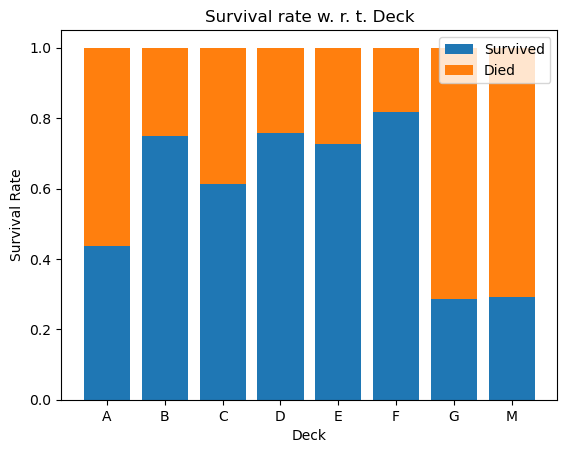

In [36]:
# Normalize the counts to be between [0, 1]
survived_by_deck_counts /= survived_by_deck_counts.sum(axis=0)

bottom = np.zeros_like(survived_by_deck_counts.columns)

fig, ax = plt.subplots()

for val in sorted(survived_by_deck_counts.index, reverse=True):
    print(val)
    subset = survived_by_deck_counts.loc[val]
    ax.bar(subset.index, subset.values, bottom=bottom, label='Survived' if val == 1 else 'Died')
    ax.legend()
    bottom += subset.values

ax.set_title('Survival rate w. r. t. Deck')
ax.set_xlabel('Deck')
ax.set_ylabel('Survival Rate')
plt.show()

In [37]:
# Join the decks used by the same class together
# and leave M deck alone

deck = deck.fillna('M')
deck = deck.replace(to_replace=['A', 'B', 'C', 'D', 'E', 'F', 'G'], value=['ABC', 'ABC', 'ABC', 'DE', 'DE', 'FG', 'FG'])
deck.value_counts()

M      998
ABC    195
DE      88
FG      28
Name: Cabin, dtype: int64

In [38]:
# Add the "Deck" column to the train_df
final_df['Deck'] = deck

final_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,LastName,FirstName,C,Q,S,Master,Miss,Mr,Mrs,Other,Deck
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0.0,3,1,22,1,0,A/5 21171,7.0,NaN,Braund,Owen Harris,0,0,1,0,0,1,0,0,M
2,1.0,1,0,38,1,0,PC 17599,71.0,C85,Cumings,John Bradley (Florence Briggs Thayer),1,0,0,0,0,0,1,0,ABC
3,1.0,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,Heikkinen,Laina,0,0,1,0,1,0,0,0,M
4,1.0,1,0,35,1,0,113803,53.0,C123,Futrelle,Jacques Heath (Lily May Peel),0,0,1,0,0,0,1,0,ABC
5,0.0,3,1,35,0,0,373450,8.0,NaN,Allen,William Henry,0,0,1,0,0,1,0,0,M


In [39]:
# Encode the Deck column to categorical integers so we can impute it
deck_encode = preprocessing.OrdinalEncoder(encoded_missing_value=-1).fit(final_df['Deck'].values.reshape(-1, 1))

print(deck_encode.categories_)

[array(['ABC', 'DE', 'FG', 'M'], dtype=object)]


In [40]:
final_df['Deck'] = deck_encode.transform(final_df['Deck'].values.reshape(-1, 1)).astype(np.int32)
final_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,LastName,FirstName,C,Q,S,Master,Miss,Mr,Mrs,Other,Deck
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0.0,3,1,22,1,0,A/5 21171,7.0,NaN,Braund,Owen Harris,0,0,1,0,0,1,0,0,3
2,1.0,1,0,38,1,0,PC 17599,71.0,C85,Cumings,John Bradley (Florence Briggs Thayer),1,0,0,0,0,0,1,0,0
3,1.0,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,Heikkinen,Laina,0,0,1,0,1,0,0,0,3
4,1.0,1,0,35,1,0,113803,53.0,C123,Futrelle,Jacques Heath (Lily May Peel),0,0,1,0,0,0,1,0,0
5,0.0,3,1,35,0,0,373450,8.0,NaN,Allen,William Henry,0,0,1,0,0,1,0,0,3


## Feature Engineering

In [41]:
final_df[(final_df.Age <= 14)][['Master', 'Miss', 'Mr', 'Mrs', 'Other']].value_counts()

Master  Miss  Mr  Mrs  Other
1       0     0   0    0        57
0       1     0   0    0        51
        0     1   0    0         5
              0   1    0         1
dtype: int64

In [42]:
final_df[(final_df['Master'] == 1) & (final_df['Age'] > 14)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,LastName,FirstName,C,Q,S,Master,Miss,Mr,Mrs,Other,Deck
PassengerId,,,,,,,,,,,,,,,,,,,,
177,0.0,3,1,24,3,1,4133,25.0,NaN,Lefebre,Henry Forbes,0,0,1,1,0,0,0,0,3
1136,NaN,3,1,20,1,2,W./C. 6607,23.0,NaN,Johnston,"William Arthur Willie""""",0,0,1,1,0,0,0,0,3
1231,NaN,3,1,28,0,0,2622,7.0,NaN,Betros,Seman,1,0,0,1,0,0,0,0,3
1309,NaN,3,1,18,1,1,2668,22.0,F E69,Peter,Michael J,1,0,0,1,0,0,0,0,2


In [43]:
# Children (defined as 'Age' <= 14) and aren't married women or have the title of 'Master'
def create_is_child_feature(df):
    is_child = (df['Age'] <= 14)
    is_child &= (df.Mrs == 1)
    is_child |= (df.Master == 1)
    is_child = is_child.astype(np.uint8)

    return is_child

is_child = create_is_child_feature(final_df)

In [44]:
final_df.corrwith(is_child, numeric_only=True, method='kendall').abs().sort_values(ascending=False)

Master      0.991505
Parch       0.355975
Age         0.284237
Mr          0.262351
SibSp       0.252110
Sex         0.158273
Miss        0.111542
Fare        0.097194
Survived    0.091011
Pclass      0.087401
Mrs         0.085593
Deck        0.044670
Other       0.029820
S           0.012666
Q           0.010179
C           0.007007
dtype: float64

In [45]:
final_df['Child'] = is_child
final_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,LastName,...,C,Q,S,Master,Miss,Mr,Mrs,Other,Deck,Child
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,1,22,1,0,A/5 21171,7.0,NaN,Braund,...,0,0,1,0,0,1,0,0,3,0
2,1.0,1,0,38,1,0,PC 17599,71.0,C85,Cumings,...,1,0,0,0,0,0,1,0,0,0
3,1.0,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,Heikkinen,...,0,0,1,0,1,0,0,0,3,0
4,1.0,1,0,35,1,0,113803,53.0,C123,Futrelle,...,0,0,1,0,0,0,1,0,0,0
5,0.0,3,1,35,0,0,373450,8.0,NaN,Allen,...,0,0,1,0,0,1,0,0,3,0


In [46]:
# Create family size feature

family_size = final_df.Parch + final_df.SibSp + 1

final_df['FamilySize'] = family_size

final_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,LastName,...,Q,S,Master,Miss,Mr,Mrs,Other,Deck,Child,FamilySize
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,1,22,1,0,A/5 21171,7.0,NaN,Braund,...,0,1,0,0,1,0,0,3,0,2
2,1.0,1,0,38,1,0,PC 17599,71.0,C85,Cumings,...,0,0,0,0,0,1,0,0,0,2
3,1.0,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,Heikkinen,...,0,1,0,1,0,0,0,3,0,1
4,1.0,1,0,35,1,0,113803,53.0,C123,Futrelle,...,0,1,0,0,0,1,0,0,0,2
5,0.0,3,1,35,0,0,373450,8.0,NaN,Allen,...,0,1,0,0,1,0,0,3,0,1


In [47]:
final_df.corrwith(final_df['FamilySize'], method='kendall', numeric_only=True).abs().sort_values(ascending=False)

FamilySize    1.000000
SibSp         0.809451
Parch         0.749900
Fare          0.417351
Mr            0.379694
Child         0.309118
Master        0.308930
Mrs           0.288323
Sex           0.258121
Survived      0.154863
Age           0.133115
Q             0.115232
Deck          0.109085
Pclass        0.078643
C             0.060888
Miss          0.049445
S             0.019604
Other         0.014490
dtype: float64

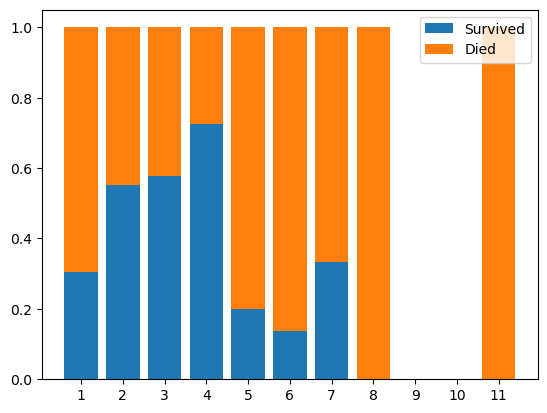

In [48]:
fig, ax = plt.subplots()

survival_rate_by_family_size = final_df.groupby(['Survived', 'FamilySize']).size()
survival_rate_by_family_size = survival_rate_by_family_size.reset_index()

# when resetting the index of a Series and your series has no name
# Pandas will create a DF where the values will belong in the 0 column.
survival_rate_by_family_size = pd.pivot(survival_rate_by_family_size, index='Survived', columns='FamilySize', values=0).fillna(0)
survival_rate_by_family_size = survival_rate_by_family_size.div(survival_rate_by_family_size.values.sum(axis=0))

bottom = np.zeros_like(survival_rate_by_family_size.columns, dtype=np.float64)

for val in sorted(survival_rate_by_family_size.index, reverse=True):
    subset = survival_rate_by_family_size.loc[val]
    ax.bar(subset.index, subset.values, bottom=bottom, label='Survived' if val == 1 else 'Died')
    bottom += subset.values

ax.set_xticks(np.arange(1, 12))
ax.legend()

plt.show()

In [49]:
# Based on the plot above we can discretize the 'FamilySize' into multiple buckets
final_df['FamilySizeCat'] = pd.cut(final_df.FamilySize, bins=[1, 2, 5, 8, 12], right=False, labels=['1', '2-4', '5-7', '8+'])
final_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,LastName,...,S,Master,Miss,Mr,Mrs,Other,Deck,Child,FamilySize,FamilySizeCat
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,1,22,1,0,A/5 21171,7.0,NaN,Braund,...,1,0,0,1,0,0,3,0,2,2-4
2,1.0,1,0,38,1,0,PC 17599,71.0,C85,Cumings,...,0,0,0,0,1,0,0,0,2,2-4
3,1.0,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,Heikkinen,...,1,0,1,0,0,0,3,0,1,1
4,1.0,1,0,35,1,0,113803,53.0,C123,Futrelle,...,1,0,0,0,1,0,0,0,2,2-4
5,0.0,3,1,35,0,0,373450,8.0,NaN,Allen,...,1,0,0,1,0,0,3,0,1,1


In [50]:
# Create group size feature

group_size = final_df.Ticket.value_counts()

final_df['GroupSize'] = final_df.Ticket.map(lambda ticket: group_size[ticket])

final_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,LastName,...,Master,Miss,Mr,Mrs,Other,Deck,Child,FamilySize,FamilySizeCat,GroupSize
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,1,22,1,0,A/5 21171,7.0,NaN,Braund,...,0,0,1,0,0,3,0,2,2-4,1
2,1.0,1,0,38,1,0,PC 17599,71.0,C85,Cumings,...,0,0,0,1,0,0,0,2,2-4,2
3,1.0,3,0,26,0,0,STON/O2. 3101282,8.0,NaN,Heikkinen,...,0,1,0,0,0,3,0,1,1,1
4,1.0,1,0,35,1,0,113803,53.0,C123,Futrelle,...,0,0,0,1,0,0,0,2,2-4,2
5,0.0,3,1,35,0,0,373450,8.0,NaN,Allen,...,0,0,1,0,0,3,0,1,1,1


In [51]:
final_df.corrwith(final_df['GroupSize'], method='kendall', numeric_only=True).abs().sort_values(ascending=False)

GroupSize     1.000000
FamilySize    0.706615
Parch         0.593747
Fare          0.590677
SibSp         0.568316
Mr            0.360724
Master        0.268161
Child         0.267939
Sex           0.260879
Mrs           0.240098
Deck          0.236458
Pclass        0.204490
Survived      0.199487
Q             0.142587
C             0.110118
Miss          0.096507
Age           0.073612
Other         0.030787
S             0.006441
dtype: float64

In [52]:
# Convert 'FamilySizeCat' to int

family_size_cat_encoder = preprocessing.OrdinalEncoder(dtype=np.uint8)
final_df['FamilySizeCat'] = family_size_cat_encoder.fit_transform(final_df.FamilySizeCat.values.reshape(-1, 1))
final_df.FamilySizeCat.value_counts()

0    790
1    437
2     63
3     19
Name: FamilySizeCat, dtype: int64

In [53]:
# The fare seems to be based on the ticket type so we could adjust it.
# TODO: test if the adjusted fare provides any help or not
final_df['AdjFare'] = round(final_df['Fare'] / final_df['GroupSize'])

In [54]:
final_df[['AdjFare', 'Fare']].corrwith(final_df['Survived'], method='kendall')

AdjFare    0.244991
Fare       0.279197
dtype: float64

In [55]:
# Extract family survival rate and group survival rate from the datasets

train_family_names = final_df.iloc[:891]['LastName'].unique()
test_family_names = final_df.iloc[892:]['LastName'].unique()
train_tickets = final_df.iloc[:891]['Ticket'].unique()
test_tickets = final_df.iloc[892:]['Ticket'].unique()

train_test_families = [x for x in train_family_names if x in test_family_names]
train_test_tickets = [x for x in train_tickets if x in test_tickets]

is_train_test_family = final_df['LastName'].isin(train_test_families)
is_train_test_ticket = final_df['Ticket'].isin(train_test_tickets)

family_survival_rate = final_df.groupby('LastName')['Survived'].transform('mean')
family_size = final_df.groupby('LastName').transform('size')

# Family sizes <= 1 aren't families so we'll set their rate to NaN
# Set family_sr for families that aren't in both datasets to NaN
family_survival_rate.loc[(family_size <= 1)] = np.nan
family_survival_rate.loc[~is_train_test_family] = np.nan

ticket_survival_rate = final_df.groupby('Ticket')['Survived'].transform('mean')
ticket_group_size = final_df.groupby('Ticket').transform('size')

# Same for tickets
ticket_survival_rate.loc[(ticket_group_size <= 1)] = np.nan
ticket_survival_rate.loc[~is_train_test_ticket] = np.nan

In [56]:
# Compute mean survival rate for the entire dataset
mean_survival_rate = final_df['Survived'].mean()

# Create marker features where survival rate is NA
family_survival_rate_na = family_survival_rate.isna().astype(np.uint8)
ticket_survival_rate_na = ticket_survival_rate.isna().astype(np.uint8)

# Fill NA with 'mean_survival_rate'
family_survival_rate = family_survival_rate.fillna(mean_survival_rate)
ticket_survival_rate = ticket_survival_rate.fillna(mean_survival_rate)

# Create 'survival_rate' as mean of 'ticket_sr' and 'family_sr', ditto for marker feature
survival_rate = (family_survival_rate + ticket_survival_rate) / 2
survival_rate_na = (family_survival_rate_na + ticket_survival_rate_na) / 2

final_df['SurvivalRate'] = survival_rate
final_df['SurvivalRateNA'] = survival_rate_na

## Explore correlations

In [57]:
# Plot 1 variable rank-correlation

df_corr = final_df.corr(method='kendall', numeric_only=True)
df_corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S,Master,Miss,Mr,Mrs,Other,Deck,Child,FamilySize,FamilySizeCat,GroupSize,AdjFare,SurvivalRate,SurvivalRateNA
Survived,1.00,-0.32,-0.54,-0.05,0.09,0.13,0.28,0.17,0.00,-0.15,0.09,0.33,-0.55,0.35,-0.03,-0.31,0.09,0.15,0.16,0.20,0.24,0.46,-0.08
Pclass,-0.32,1.00,0.12,-0.32,-0.06,-0.03,-0.61,-0.23,0.23,0.06,0.09,0.03,0.11,-0.18,-0.14,0.66,0.09,-0.08,-0.10,-0.20,-0.75,-0.20,0.06
Sex,-0.54,0.12,1.00,0.08,-0.18,-0.24,-0.22,-0.07,-0.09,0.12,0.16,-0.67,0.87,-0.58,0.09,0.15,0.16,-0.26,-0.27,-0.26,-0.08,-0.17,0.18
Age,-0.05,-0.32,0.08,1.00,-0.11,-0.16,0.13,0.06,-0.07,-0.01,-0.28,-0.25,0.17,0.18,0.12,-0.24,-0.28,-0.13,-0.12,-0.07,0.29,0.05,0.07
SibSp,0.09,-0.06,-0.18,-0.11,1.00,0.42,0.37,0.03,-0.08,0.03,0.25,0.02,-0.28,0.22,-0.00,-0.08,0.25,0.81,0.84,0.57,-0.04,-0.02,-0.43
Parch,0.13,-0.03,-0.24,-0.16,0.42,1.00,0.33,0.03,-0.12,0.05,0.36,0.11,-0.38,0.19,-0.02,-0.07,0.36,0.75,0.70,0.59,-0.14,0.09,-0.45
Fare,0.28,-0.61,-0.22,0.13,0.37,0.33,1.00,0.18,-0.19,-0.04,0.10,0.05,-0.27,0.23,0.07,-0.50,0.10,0.42,0.44,0.59,0.54,0.12,-0.33
C,0.17,-0.23,-0.07,0.06,0.03,0.03,0.18,1.00,-0.16,-0.78,-0.01,-0.01,-0.06,0.10,0.00,-0.28,-0.01,0.06,0.08,0.11,0.17,0.14,-0.06
Q,0.00,0.23,-0.09,-0.07,-0.08,-0.12,-0.19,-0.16,1.00,-0.49,-0.01,0.20,-0.08,-0.10,-0.00,0.14,-0.01,-0.12,-0.12,-0.14,-0.12,0.00,0.04
S,-0.15,0.06,0.12,-0.01,0.03,0.05,-0.04,-0.78,-0.49,1.00,0.02,-0.11,0.11,-0.03,-0.00,0.16,0.01,0.02,0.01,-0.01,-0.08,-0.13,0.03


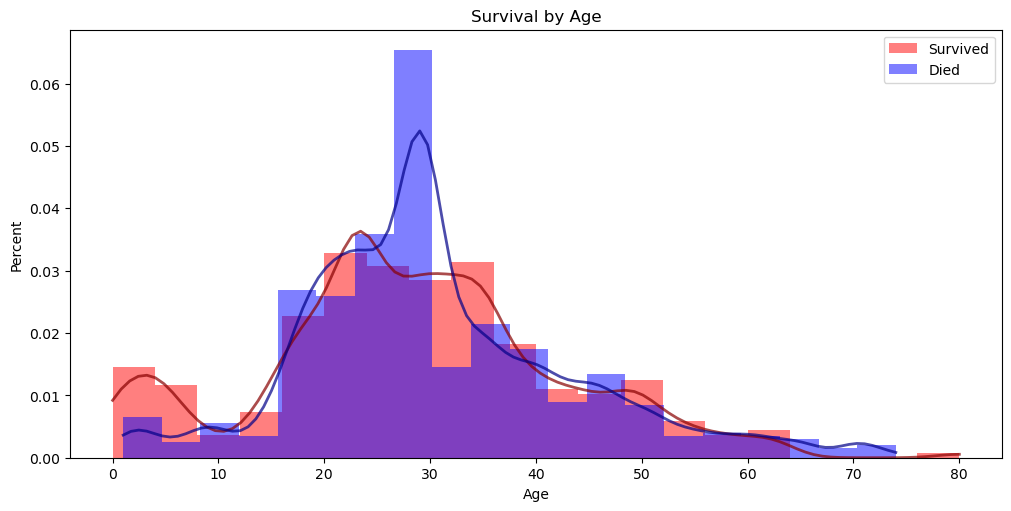

In [58]:
# Plot correlation of continous features

fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(10, 5)

age_survived = final_df[final_df.Survived == 1].Age
age_died = final_df[final_df.Survived == 0].Age

ax.hist(age_survived, bins=20, density=True, color='#ff0000', alpha=.5, label='Survived')
x = np.linspace(age_survived.min(), age_survived.max(), 100)
density = stats.gaussian_kde(age_survived, bw_method=.15)
ax.plot(x, density(x), color='#880000', linewidth=2, alpha=.7)

ax.hist(age_died, bins=20, density=True, color='#0000ff', alpha=.5, label='Died')
x = np.linspace(age_died.min(), age_died.max(), 100)
density = stats.gaussian_kde(age_died, bw_method=.15)
ax.plot(x, density(x), color='#000088', linewidth=2, alpha=.7)

ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Percent')
ax.set_title('Survival by Age')

plt.show()

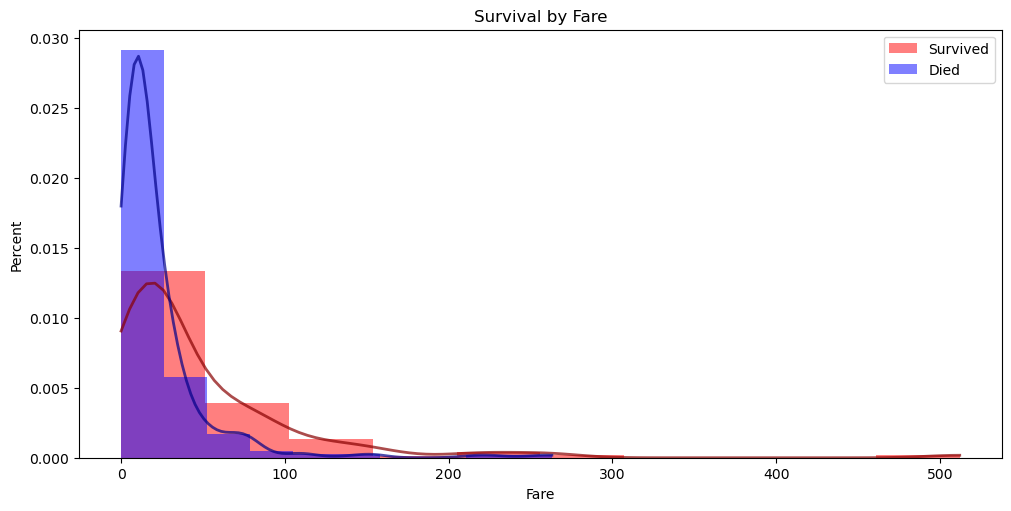

In [59]:
fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(10, 5)

fare_survived = final_df[final_df.Survived == 1].Fare
fare_died = final_df[final_df.Survived == 0].Fare

ax.hist(fare_survived, bins=10, density=True, color='#ff0000', alpha=.5, label='Survived')
x = np.linspace(fare_survived.min(), fare_survived.max(), 100)
density = stats.gaussian_kde(fare_survived.astype(np.float32), bw_method=.3)
ax.plot(x, density(x), color='#880000', linewidth=2, alpha=.7)

ax.hist(fare_died, bins=10, density=True, color='#0000ff', alpha=.5, label='Died')
x = np.linspace(fare_died.min(), fare_died.max(), 100)
density = stats.gaussian_kde(fare_died.astype(np.float32), bw_method=.3)
ax.plot(x, density(x), color='#000088', linewidth=2, alpha=.7)

ax.legend()
ax.set_xlabel('Fare')
ax.set_ylabel('Percent')
ax.set_title('Survival by Fare')

plt.show()

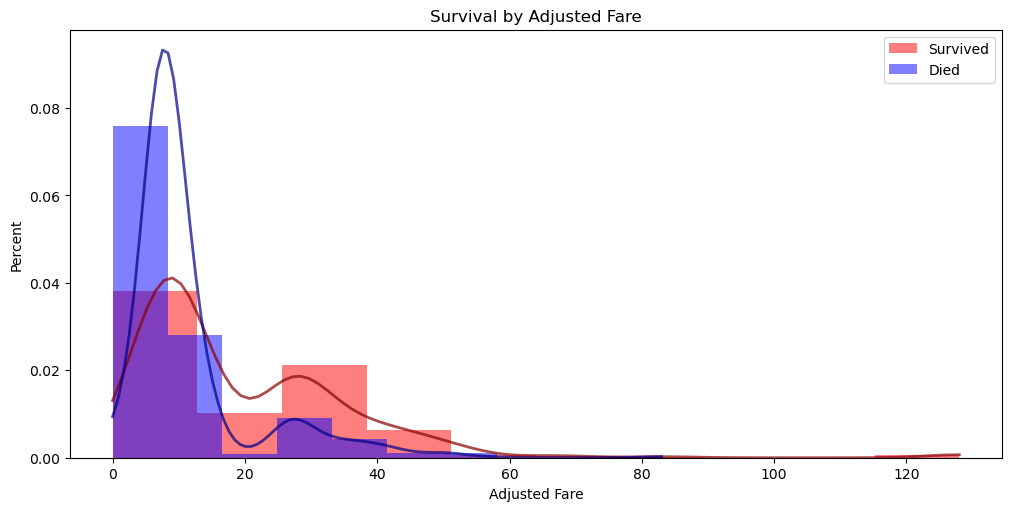

In [60]:
fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(10, 5)

adj_fare_survived = final_df[final_df.Survived == 1].AdjFare
adj_fare_died = final_df[final_df.Survived == 0].AdjFare

ax.hist(adj_fare_survived, bins=10, density=True, color='#ff0000', alpha=.5, label='Survived')
x = np.linspace(adj_fare_survived.min(), adj_fare_survived.max(), 100)
density = stats.gaussian_kde(adj_fare_survived.astype(np.float32), bw_method=.3)
ax.plot(x, density(x), color='#880000', linewidth=2, alpha=.7)

ax.hist(adj_fare_died, bins=10, density=True, color='#0000ff', alpha=.5, label='Died')
x = np.linspace(adj_fare_died.min(), adj_fare_died.max(), 100)
density = stats.gaussian_kde(adj_fare_died.astype(np.float32), bw_method=.3)
ax.plot(x, density(x), color='#000088', linewidth=2, alpha=.7)

ax.legend()
ax.set_xlabel('Adjusted Fare')
ax.set_ylabel('Percent')
ax.set_title('Survival by Adjusted Fare')

plt.show()

In [61]:
# TODO
# Plot correlation of categorical features (Pclass, Sex, Deck)

## Create the training/test datasets

In [63]:
train = final_df.loc[train_df.index]
test = final_df.loc[test_df.index]

In [64]:
# Create custom scaler to scale multiple columns at the same time

from typing import List

class MultiColumnStandardScaler(base.TransformerMixin):
    """
        Custom scaler that uses StandardScaler to scale only certain columns
        * param: columns - columns to be scaled by StandardScaler
    """
    def __init__(self, columns: List[str]) -> None:
        self.__cols = columns
        self.__scalers = dict()
    
    def fit(self, X, y=None):
        for col in self.__cols:
            scaler = preprocessing.StandardScaler()
            scaler.fit(X[col].values.reshape(-1, 1))
            self.__scalers[col] = scaler

        return self
    
    def transform(self, X):
        new_data = X.copy()
        for col in self.__cols:
            scaler = self.__scalers[col]
            new_data[col] = scaler.transform(X[col].values.reshape(-1, 1))
        return new_data

In [65]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'LastName', 'FirstName', 'C', 'Q', 'S', 'Master', 'Miss', 'Mr',
       'Mrs', 'Other', 'Deck', 'Child', 'FamilySize', 'FamilySizeCat',
       'GroupSize', 'AdjFare', 'SurvivalRate', 'SurvivalRateNA'],
      dtype='object')

In [66]:
# Create train datasets

ycol = 'Survived'
# Remove the columns that aren't suitable for the model to train on
# Remove the 'Fare' column since we've defined the 'AdjFare' instead
# Remove the 'Master' column since it's information is already encoded in 'Child' col.
# Remove the 'FamilySize' column since we'll use the 'FamilySizeCat' column
# Remove the 'Other' column since it doesn't seem to be correlated with 'Survival'
features = final_df.columns.difference([ycol, 'Ticket', 'LastName', 'FirstName', 'Cabin', 'Fare', 'Master', 'FamilySize', 'Other', 'Mr'])

x_train = train[features]
y_train = train[ycol]

columns_to_scale = ['AdjFare', 'Age']

In [67]:
x_train

,AdjFare,Age,C,Child,Deck,FamilySizeCat,GroupSize,Miss,Mrs,Parch,Pclass,Q,S,Sex,SibSp,SurvivalRate,SurvivalRateNA
PassengerId,,,,,,,,,,,,,,,,,
1,7.0,22,0,0,3,1,1,0,0,0,3,0,1,1,1,0.383838,1.0
2,36.0,38,1,0,0,1,2,0,1,0,1,0,0,0,1,1.000000,0.0
3,8.0,26,0,0,3,0,1,1,0,0,3,0,1,0,0,0.383838,1.0
4,26.0,35,0,0,0,1,2,0,1,0,1,0,1,0,1,0.383838,1.0
5,8.0,35,0,0,3,0,1,0,0,0,3,0,1,1,0,0.383838,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,13.0,27,0,0,3,0,1,0,0,0,2,0,1,1,0,0.383838,1.0
888,30.0,19,0,0,0,0,1,1,0,0,1,0,1,0,0,0.383838,1.0
889,6.0,20,0,0,3,1,4,1,0,2,3,0,1,0,1,0.000000,0.0


In [68]:
y_train

PassengerId
1      0.0
2      1.0
3      1.0
4      1.0
5      0.0
      ... 
887    0.0
888    1.0
889    0.0
890    1.0
891    0.0
Name: Survived, Length: 891, dtype: float64

## Train models on the training set

In [69]:
# Train logistic regression model

log_regression_params = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

pipe = pipeline.Pipeline(steps=[('scaler', MultiColumnStandardScaler(columns_to_scale)),
                                ('clf', linear_model.LogisticRegression(max_iter=1000))])
search = GridSearchCV(pipe, param_grid=log_regression_params, refit=True, cv=kf)
search.fit(x_train, y_train)

print(f'Best CV score: {search.best_score_:.3f}')
print(search.best_params_)

Best CV score: 0.864
{'clf__C': 1}


In [70]:
round(search.score(x_train, y_train), 4)

0.8631

In [71]:
from sklearn.model_selection import StratifiedKFold, cross_val_score


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipe = pipeline.Pipeline([('scaler', MultiColumnStandardScaler(columns_to_scale)),
                        ('clf', ensemble.RandomForestClassifier(criterion='gini', 
                                            n_estimators=1100,
                                            max_depth=5,
                                            min_samples_split=4,
                                            min_samples_leaf=5,
                                            max_features='sqrt',
                                            oob_score=True,
                                            random_state=42,
                                            n_jobs=-1,
                                            verbose=1))])

search = cross_val_score(pipe, x_train, y_train, cv=kf)

print(f'Best CV mean: {search.mean():.3f} (std): {search.std():.3f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 794 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    3.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1100 out of 1100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBac

Best CV mean: 0.856 (std): 0.020


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1100 out of 1100 | elapsed:    0.1s finished


In [72]:
pipe = pipeline.Pipeline([('scaler', MultiColumnStandardScaler(columns_to_scale)),
                        ('clf', ensemble.RandomForestClassifier(criterion='gini', 
                                            n_estimators=1100,
                                            max_depth=5,
                                            min_samples_split=4,
                                            min_samples_leaf=5,
                                            max_features='sqrt',
                                            oob_score=True,
                                            random_state=42,
                                            n_jobs=-1,
                                            verbose=1))])

pipe.fit(x_train, y_train)

round(pipe.score(x_train, y_train), 3)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1100 out of 1100 | elapsed:    0.2s finished


0.866

In [74]:
for feature, importance in sorted(zip(features, pipe['clf'].feature_importances_), key=lambda x: x[1], reverse=True):
    print(f'{feature}: {importance:.4f}')

Sex: 0.2688
SurvivalRate: 0.2347
Mrs: 0.0805
Miss: 0.0770
Pclass: 0.0648
AdjFare: 0.0617
Deck: 0.0526
Age: 0.0465
GroupSize: 0.0324
FamilySizeCat: 0.0216
SurvivalRateNA: 0.0151
SibSp: 0.0122
Child: 0.0118
Parch: 0.0078
S: 0.0056
C: 0.0046
Q: 0.0023


In [75]:
counts = y_train.value_counts(normalize=True)

scale_pos_weight = counts.iloc[0] / counts.iloc[1]
print(scale_pos_weight)

counts

1.605263157894737


0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64

In [76]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_params = {
    # 'booster': ['gbtree', 'dart'],
    'clf__learning_rate': (0, 1),
    'clf__gamma': (1e-6, 1e+6, 'log-uniform'),
    'clf__max_depth': (4, 7),
    'clf__min_child_weight': (1, 1e+6, 'log-uniform'),
    'clf__reg_lambda': (1e-5, 1e+5, 'log-uniform'),
    'clf__reg_alpha': (1e-5, 1e+5, 'log-uniform')
}

pipe = pipeline.Pipeline([('scaler', MultiColumnStandardScaler(columns_to_scale)),
                        ('clf', XGBClassifier(subsample=0.5,
                                              max_bin=1000,
                                              scale_pos_weight=scale_pos_weight))])
bsearch = BayesSearchCV(pipe, n_iter=50, search_spaces=search_params, cv=kf, refit=True)
bsearch.fit(x_train, y_train)

print(f'XGBoost score: {bsearch.best_score_:.3f}')
print(f'    (params): {bsearch.best_params_}')

XGBoost score: 0.864
    (params): OrderedDict([('clf__gamma', 6.60234755598586e-06), ('clf__learning_rate', 1), ('clf__max_depth', 4), ('clf__min_child_weight', 2), ('clf__reg_alpha', 1e-05), ('clf__reg_lambda', 200.87645033039692)])


In [78]:
for feature, importance in sorted(zip(features, bsearch.best_estimator_['clf'].feature_importances_), key=lambda x: x[1], reverse=True):
    print(f'{feature}: {importance:.4f}')

Sex: 0.4089
SurvivalRate: 0.1517
Pclass: 0.0892
Deck: 0.0586
AdjFare: 0.0331
Age: 0.0280
FamilySizeCat: 0.0275
GroupSize: 0.0257
Parch: 0.0244
C: 0.0240
Miss: 0.0213
Mrs: 0.0195
Child: 0.0190
S: 0.0182
SurvivalRateNA: 0.0179
Q: 0.0176
SibSp: 0.0154


## Predict on the test data

In [79]:
x_test = test[features]
test_survived = bsearch.predict(x_test)

result_df = pd.DataFrame({'PassengerId':test.index, 'Survived':test_survived.astype(np.int32)})
result_df.head(n=10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,1
8,900,1
9,901,0


In [80]:
result_df.to_csv('./new_submission.csv', header=True, index=False) # 78.0%